# Numerical linear algebra, preconditioning, and the irreversibility of chaos

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/numerical_linear_algebra_preconditioning.ipynb) -->
Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/numerical_linear_algebra_preconditioning.ipynb)

In [1]:
## Preamble / required packages
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline


# Appendix / Future

As a physics example, we consider a large $2D$ network of $N$ point masses of equal length $m$ connected by springs of random resistivity and resting length $\mathbf{r}_0$. If $\mathbf{r}(t) \in \mathbb{R}^{2N}$ is the vector of positions of the point masses, then the equations of motion with damping are given by

$$
m \ddot{\mathbf{x}} = -\gamma \dot{\mathbf{x}} - K \mathbf{x}
$$

where we define the displacement vector $\mathbf{x} = \mathbf{r} - \mathbf{r}_0$, where $K \in \mathbb{R}^{2N \times 2N}$ is the matrix of resistivities. We assume that we are in the overdamped regime $\gamma / m \gg 1$, so that the inertial term is negligible,

$$
\dot{\mathbf{r}} = -\frac{1}{\gamma} K \mathbf{x}
$$

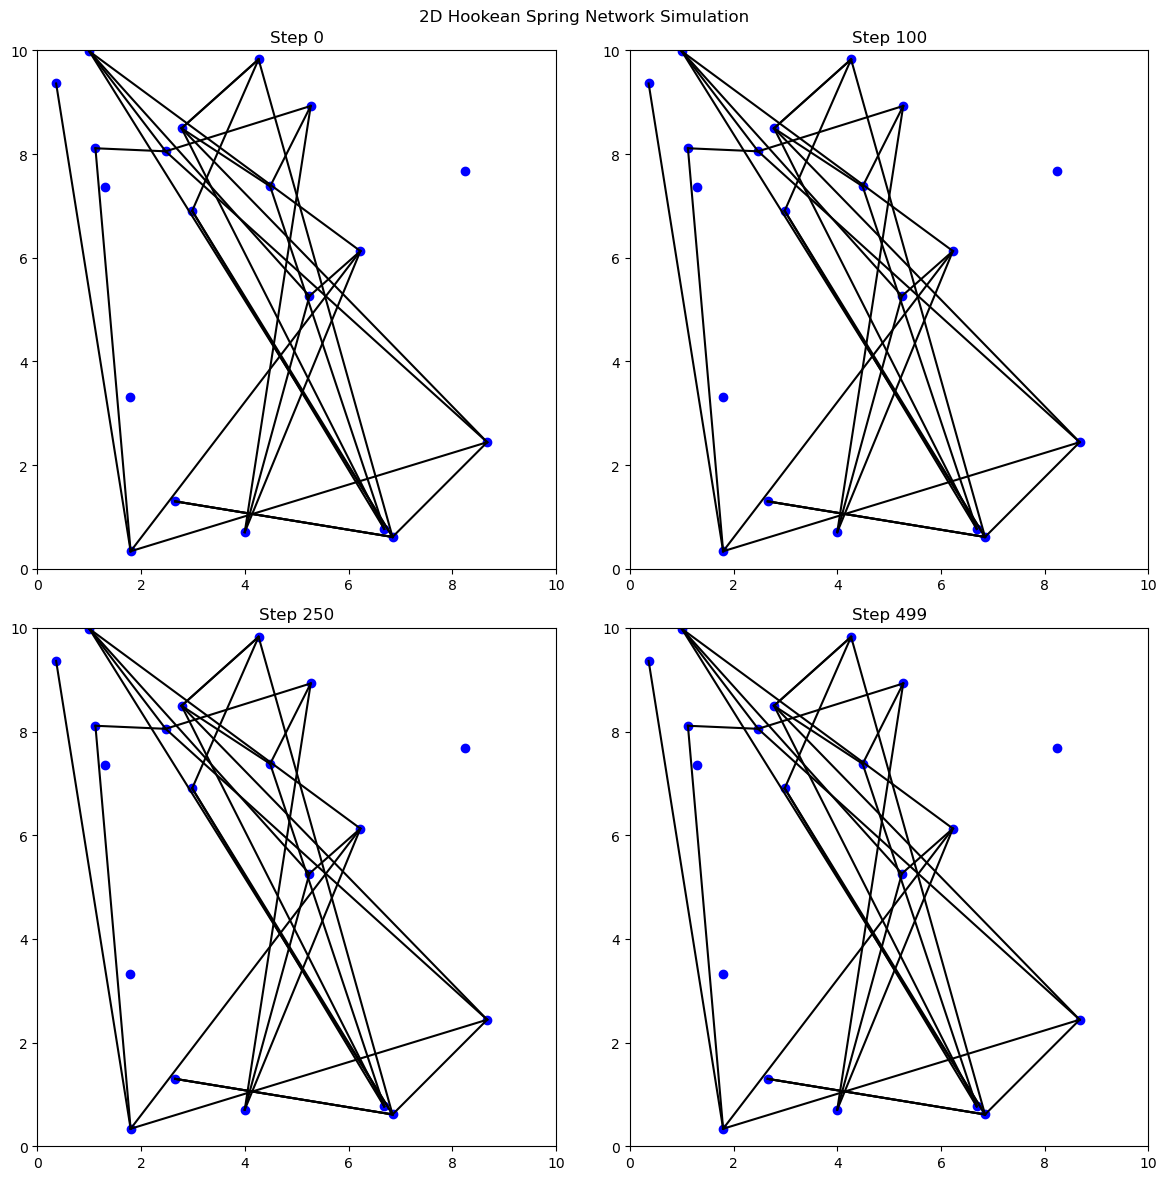

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Particle:
    def __init__(self, x, y, mass=1.0):
        self.position = np.array([x, y])
        self.velocity = np.zeros(2)
        self.acceleration = np.zeros(2)
        self.mass = mass

    def update(self, dt):
        self.velocity += self.acceleration * dt
        self.position += self.velocity * dt
        self.acceleration = np.zeros(2)

class Spring:
    def __init__(self, particle1, particle2, stiffness, rest_length):
        self.particle1 = particle1
        self.particle2 = particle2
        self.stiffness = stiffness
        self.rest_length = rest_length

    def apply_force(self):
        displacement = self.particle2.position - self.particle1.position
        distance = np.linalg.norm(displacement)
        force_magnitude = self.stiffness * (distance - self.rest_length)
        force = force_magnitude * displacement / distance
        
        self.particle1.acceleration += force / self.particle1.mass
        self.particle2.acceleration -= force / self.particle2.mass

# Simulation parameters
num_particles = 20
num_springs = 30
box_size = 10
dt = 0.01
stiffness = 5.0
damping = 0.1
num_steps = 500
plot_steps = [0, 100, 250, 499]  # Steps at which to plot the network

# Create random particles
particles = [Particle(np.random.uniform(0, box_size), np.random.uniform(0, box_size)) for _ in range(num_particles)]

# Create random springs
springs = []
for _ in range(num_springs):
    p1, p2 = np.random.choice(particles, 2, replace=False)
    rest_length = np.linalg.norm(p1.position - p2.position)
    springs.append(Spring(p1, p2, stiffness, rest_length))

# Set up the plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("2D Hookean Spring Network Simulation")
axs = axs.flatten()

# Simulation loop
for step in range(num_steps):
    # Apply spring forces
    for spring in springs:
        spring.apply_force()
    
    # Update particle positions
    for particle in particles:
        particle.velocity *= (1 - damping)  # Apply damping
        particle.update(dt)
    
    # Plot at specified steps
    if step in plot_steps:
        ax = axs[plot_steps.index(step)]
        ax.clear()
        ax.set_xlim(0, box_size)
        ax.set_ylim(0, box_size)
        ax.set_aspect('equal')
        ax.set_title(f"Step {step}")
        
        # Plot particles
        x = [p.position[0] for p in particles]
        y = [p.position[1] for p in particles]
        ax.plot(x, y, 'bo', markersize=6)
        
        # Plot springs
        for spring in springs:
            x = [spring.particle1.position[0], spring.particle2.position[0]]
            y = [spring.particle1.position[1], spring.particle2.position[1]]
            ax.plot(x, y, 'k-')

plt.tight_layout()
plt.show()

In [ ]:
# use networkx to create a random spring network

import networkx as nx

# Create a random spring network
G = nx.random_geometric_graph(100, 0.2, seed=1)

# random connected small graph
G = nx.random_tree(7, seed=1)

# plot the network
plt.figure(figsize=(5, 5))
nx.draw(G, node_size=10, node_color='r', width=0.5)


# # Get the adjacency matrix
A = nx.adjacency_matrix(G).todense()

# simulate forces subject to the spring network

from scipy.spatial.distance import cdist

class RandomSpringNetwork:
    """Given a networkx graph, simulate the dynamics of a random spring network"""

    def __init__(self, G, dt=0.01, random_state=None, store_history=False):
        self.dt = dt
        self.random_state = random_state
        self.store_history = store_history
        self.n = len(G.nodes)
        self.A = nx.adjacency_matrix(G).todense()
        self.pos = np.random.random((self.n, 2))
        self.vel = np.zeros((self.n, 2))
        self.acc = np.zeros((self.n, 2))
        self.forces = np.zeros((self.n, 2))
        self.step = 0
        
        # resting length
        self.rest_length = 0.3 * np.random.random(self.n)

        if self.store_history:
            self.history = [self.pos.copy()]

    def simulate(self, steps=100):
        """Simulate the dynamics of the spring network for a given number of steps"""
        for _ in range(steps):
            self.step += 1
            self.compute_forces()
            self.update()
            self.update_positions()

    def compute_forces(self):
        """Compute the forces acting on each node"""
        self.forces = np.zeros((self.n, 2))
        for i in range(self.n):
            for j in range(self.n):
                if i != j and self.A[i, j]:
                    ## compute the forces between node i and node j accounting
                    ## for the resting length of the spring
                    self.forces[i] += 0.1 * (self.pos[j] - self.pos[i]) * (np.linalg.norm(self.pos[j] - self.pos[i]) - self.rest_length[i])

    def update(self):
        """Update the velocity and acceleration of each node"""
        self.acc = self.forces
        self.vel += self.acc * self.dt

        # overdamped limit
        self.vel = self.forces

    def update_positions(self):
        """Update the position of each node"""
        self.pos += self.vel * self.dt
        if self.store_history:
            self.history.append(self.pos.copy())

eq = RandomSpringNetwork(G, dt=0.1, random_state=0, store_history=True)
eq.simulate(steps=5000)

# plot the network
plt.figure(figsize=(5, 5))
nx.draw(G, pos=eq.pos, node_size=10, node_color='r', width=0.5)


In [ ]:
from scipy.spatial.distance import cdist


def find_fixed_point(K, R0, X0):
    N, _ = X0.shape
    unit_vectors = X0[:, None, :] - X0[None, :, :]  # N x N x 2 array of vector differences
    distances = np.linalg.norm(unit_vectors, axis=2)  # N x N distance matrix
    distances += np.finfo(float).eps
    direction_matrices = np.divide(unit_vectors, distances[:, :, None], where=distances[:, :, None]!=0)  # normalize, safely handling divide by zero

    # Calculate the force matrices with the given resting length
    F_matrices = K[:, :, None] * (distances[:, :, None] - R0[:, None, None]) * direction_matrices

    # Setting up the matrix equation AX = B to solve for X
    A = np.einsum('ijk,ijl->ikl', direction_matrices, K[:, :, None] * direction_matrices)  # Constructing the A matrix with dot products

    # Formulating B matrix
    B = -np.sum(F_matrices, axis=1)  # Summing the forces to get the net force (B vector)

    # Finding the fixed point by solving the matrix equation
    fixed_point_positions = np.linalg.solve(A, B)
    
    return fixed_point_positions


s = find_fixed_point(eq.A, eq.rest_length, eq.history[0])

In [ ]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

## Find fixed axis bounds
vmax = np.max(np.array(eq.history), axis=(0, 1))
vmin = np.min(np.array(eq.history), axis=(0, 1))

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(6, 6))
    # plt.imshow(eq.pos_history[i], vmin=0, vmax=1, cmap="gray")
    nx.draw(G, pos=eq.history[i], node_size=10, node_color='r', width=0.5)
    plt.xlim(vmin[0], vmax[0])
    plt.ylim(vmin[1], vmax[1])
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(eq.history) - 1, 1, layout=Layout(width='800px'))
)